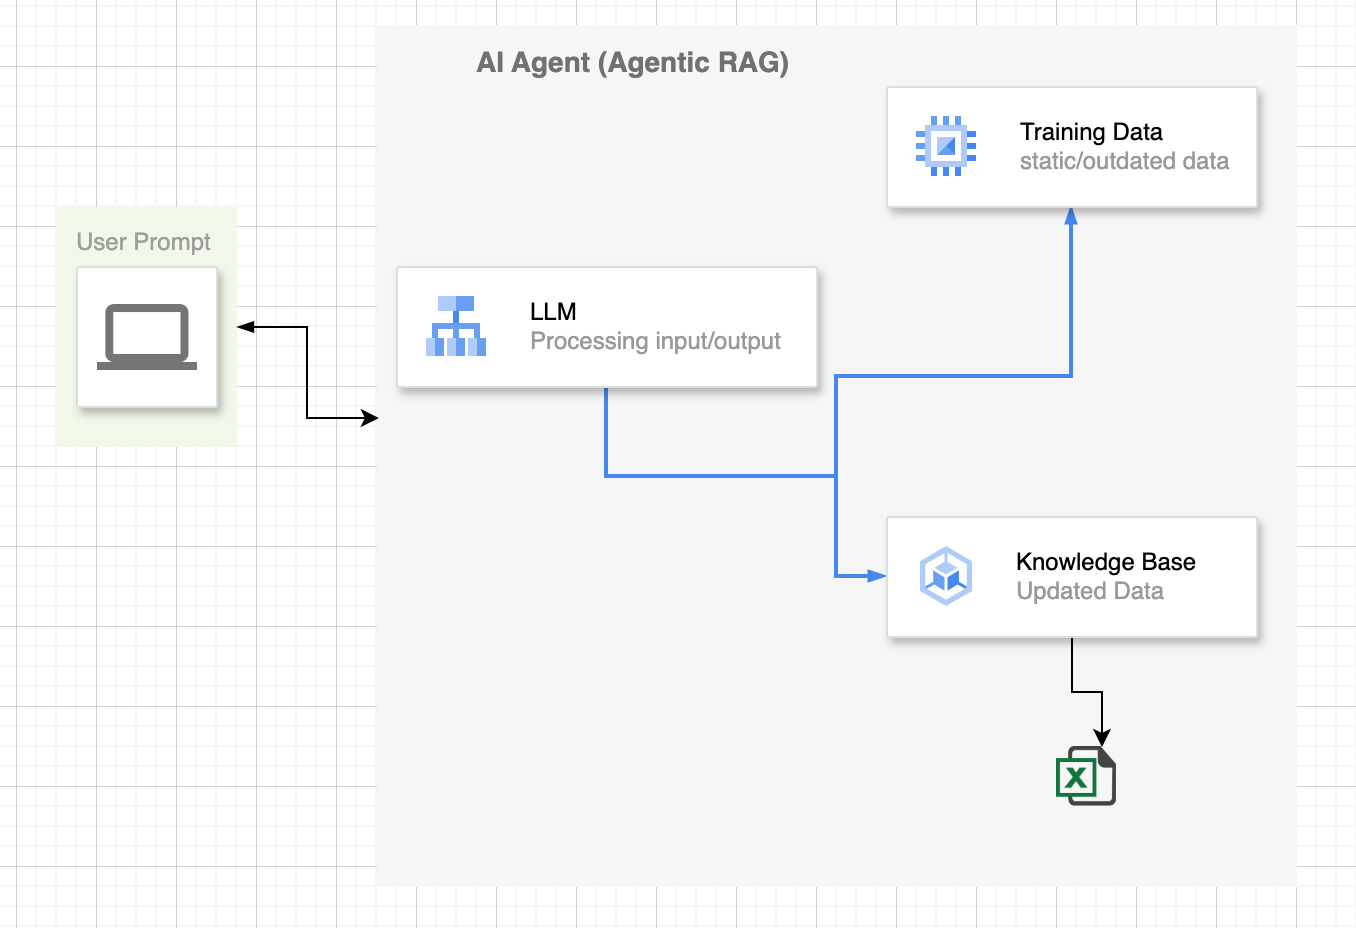

**1) Set up Google Drive:**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2) Set up dependencies:**

In [7]:
!pip install --quiet langchain huggingface_hub faiss-cpu pandas python-dotenv
!pip install --quiet datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 41.9 MB/s eta 0:00:00


**3) Set up Inference serverless API:**



In [8]:
from huggingface_hub import notebook_login
notebook_login()

**4) Set up dataset and dataframe:**

In [9]:
import pandas as pd
import datasets
from datasets import Dataset
from langchain.docstore.document import Document
excel_path = '/content/drive/MyDrive/Colab Notebooks/base_acme_2025.xlsx'
df = pd.read_excel(excel_path)
print(f"Filas cargadas: {len(df)}")

from datasets import Dataset
hf_dataset = Dataset.from_pandas(df)
print(hf_dataset)

from langchain.docstore.document import Document


Filas cargadas: 1
Dataset({
    features: ['aseguradora', 'coberturas_incluidas', 'precio_aproximado_anual', 'precio_aproximado_mensual', 'deducible_value', 'asistencia_en_viaje', 'vehiculo_de_sustitucion', 'descuentos_y_bonificaciones', 'red_de_talleres', 'proceso_de_reclamaciones', 'valoracion_de_clientes', 'observaciones_adicionales'],
    num_rows: 1
})


**5) Create Document Object LangGraph:**

In [10]:
from langchain.docstore.document import Document
hf_dataset = Dataset.from_pandas(df)
print(hf_dataset)

documents = []
for idx, example in enumerate(hf_dataset):
    aseguradora = example['aseguradora']
    coberturas = example['coberturas_incluidas']
    precio_anual = example['precio_aproximado_anual']
    precio_mensual = example['precio_aproximado_mensual']
    deducible_value = example['deducible_value']
    asistencia_en_viaje = example['asistencia_en_viaje']
    vehiculo_de_sustitucion = example['vehiculo_de_sustitucion']
    descuentos_y_bonificaciones = example['descuentos_y_bonificaciones']
    red_de_talleres = example['red_de_talleres']
    proceso_de_reclamaciones = example['proceso_de_reclamaciones']
    valoracion_de_clientes = example['valoracion_de_clientes']
    observaciones_adicionales = example['observaciones_adicionales']

    text = (
        f"Aseguradora: {aseguradora}\n"
        f"Coberturas incluidas: {coberturas}\n"
        f"Precio aproximado anual: {precio_anual}\n"
        f"Precio aproximado mensual: {precio_mensual}"
        f"Deducible: {deducible_value}"
        f"Asistencia En Viaje: {asistencia_en_viaje}"
        f"Vehículo De Sustitución: {vehiculo_de_sustitucion}"
        f"Descuentos Y Bonificaciones: {descuentos_y_bonificaciones}"
        f"Red De Talleres: {red_de_talleres}"
        f"Proceso De Rclamaciones: {proceso_de_reclamaciones}"
        f"Valoración De Clientes: {valoracion_de_clientes}"
        f"Observaciones Adicionales: {observaciones_adicionales}"
    )
    doc = Document(
        page_content=text,
        metadata={
            "row": idx,
            "aseguradora": aseguradora,
            "precio_anual": precio_anual,
            "precio_mensual": precio_mensual,
            "deducible_value": deducible_value,
            "asistencia_en_viaje": asistencia_en_viaje,
            "vehiculo_de_sustitucion": vehiculo_de_sustitucion,
            "descuentos_y_bonificaciones": descuentos_y_bonificaciones,
            "red_de_talleres": red_de_talleres,
            "proceso_de_reclamaciones": proceso_de_reclamaciones,
            "valoracion_de_clientes": valoracion_de_clientes,
            "observaciones_adicionales": observaciones_adicionales
        }
    )
    documents.append(doc)

print(f"Document objects creados: {len(documents)}")

Dataset({
    features: ['aseguradora', 'coberturas_incluidas', 'precio_aproximado_anual', 'precio_aproximado_mensual', 'deducible_value', 'asistencia_en_viaje', 'vehiculo_de_sustitucion', 'descuentos_y_bonificaciones', 'red_de_talleres', 'proceso_de_reclamaciones', 'valoracion_de_clientes', 'observaciones_adicionales'],
    num_rows: 1
})
Document objects creados: 1


**6) Set up Retriever tool(LangGraph):**

In [11]:
!pip install langchain_community
from langchain_community.retrievers import BM25Retriever
from langchain.tools import Tool
!pip install rank_bm25

bm25_retriever = BM25Retriever.from_documents(documents)


def extract_text(query: str) -> str:
    """Retrieve detailed information about Acme's auto insurance policies."""
    results = bm25_retriever.invoke(query)
    if results:
        return "\n\n".join([doc.page_content for doc in results[:3]])
    else:
        return "No matching guest information found."

guest_info_tool = Tool(
    name="service_info_retriever",
    func=extract_text,
    description="Retrieve detailed information about Acme's auto insurance policies."
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00


**7) Set up Agent and setup RAG:**

In [12]:
!pip install langgraph
!pip install langchain_huggingface
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.5 MB/s eta 0:00:00


**8) Set up Graph Agent, nodes, tools, etc:**

In [13]:
# Generate the chat interface, including the tools
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-Coder-32B-Instruct",
    huggingfacehub_api_token=hf_token,
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [guest_info_tool]
chat_with_tools = chat.bind_tools(tools)

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
patrick = builder.compile()

**9) Asking to AI Agentic:**

In [14]:
messages = [HumanMessage(content="¿Cuál es el precio aproximado anual de un plan?")]
response = patrick.invoke({"messages": messages})

print("🎩 Patrick's Response:")
print(response['messages'][-1].content)

🎩 Patrick's Response:
Según la información proporcionada por la aseguradora Acme, el precio aproximado anual de un plan de seguro de autos varía entre $500.000 y $1.103.000, dependiendo del modelo y del deducible elegido.
